In [463]:
from __future__ import division
import tqdm
import glob
import numpy as np
import sys
sys.path.append('/workspace/projects/TES/scripts/TESPulseFitCode')
sys.path.append('/workspace/projects/TES/scripts')
import pulse_fit_v05 as pf
import single_photon_model_no_shift as noshift
import heralded_pulses_analysis as hpa
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
import pymc
import matplotlib
import seaborn
from scipy.signal import savgol_filter
%matplotlib inline

# Single Photon Model

In [3]:
# Imports single diode excitation traces
directory_name = '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/single/'
results_directory = './'
filelist = np.array(glob.glob(directory_name + '*.trc'))
print(filelist[:2])

[ '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/single/C2_diode_single_20MHz_bwl_00000.trc'
 '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/single/C2_diode_single_20MHz_bwl_00001.trc']


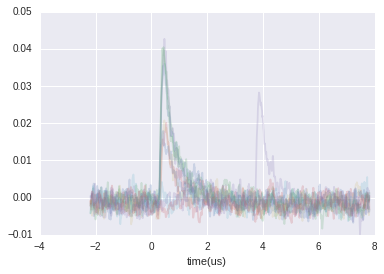

In [4]:
# Performs an initial plot
hpa.pplot(filelist[:100])

In [7]:
# Set left and right time limits of each trace to process
t_initial = None
t_final = None
height_th = 0.03 #to be updated with pt of minimal overlap between n=0 and n=1 distributions

In [279]:
# Extract trace properties, generate height histogram
data = np.array([hpa.param_extr(f,t_initial,t_final,height_th)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [01:17<00:00, 128.33it/s]


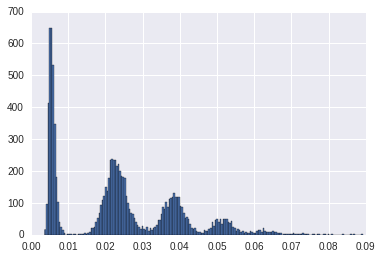

In [280]:
heights = data['height']
pnr_height = np.histogram(heights, 200)
plt.hist(heights,200);

In [309]:
# Noise Amplitude Standard Deviation
from scipy.stats import norm
(mu0,sigma0) = norm.fit(heights[(heights<0.01)])
print mu0, sigma0, sigma0/mu0

0.00565040159592 0.000824912676059 0.145991866605


In [301]:
# Single Photon Amplitude Standard Deviation
(mu,sigma) = norm.fit(heights[(heights>0.01)&(heights<0.03)])
print mu, sigma, sigma/mu

0.0227044772638 0.00287569093647 0.126657438666


In [10]:
# Detect valleys separating peaks
th = thres_poiss.thresholds_N(pnr_height, min_peak_sep=0.01, weighted=True)
print th

[(0.0092429962867481442, 1.445206458844829e-06, 3.5130640685387959e-07), (0.030346351784170569, 0.0037773252613706298, 0.003837884921989998), (0.044774694043599753, 0.0092672882527199511, 0.0093853842729076931)]


In [12]:
# Update height threshold, ,reprocess trace parameters
height_th = th[0][0]
print height_th

0.00924299628675


In [13]:
data = np.array([hpa.param_extr(f,t_initial,t_final,h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [00:38<00:00, 257.63it/s]


In [162]:
# Generate Height and Area histograms
heights = data['height']
areas = data['area_win']

# use the area to count the number of photons
pnr_height = np.histogram(heights, 200)
pnr = np.histogram(areas, 200)

# remove the first bin that is not gaussian, and will affect the threshold detection algorithm

pnr = [pnr[0][1:], pnr[1][1:]]

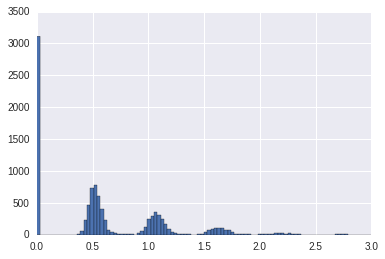

In [165]:
# Plot area histogram to survey area distinguishibility
# First bin will still be visible
# %matplotlib
plt.hist(areas,100,
         range=(0,3)
        );

In [164]:
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10124 but corresponding boolean dimension is 10000
  app.launch_new_instance()


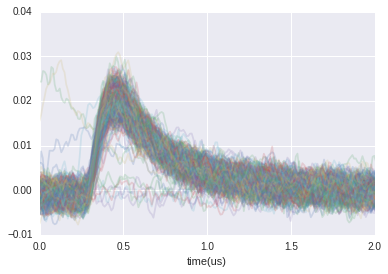

In [31]:
mask_1ph = (areas>0.2)&(areas<0.857)
# reload(hpa)
hpa.pplot(filelist[mask_1ph])
plt.xlim(0,2);

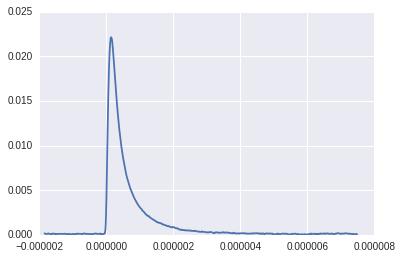

In [40]:
# Generate average pulse without horizontal offset correction
reload(hpa)
time_p, signal_p = pa.trace_ave(filelist[np.where(mask_1ph)], t_initial, t_final)

# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

In [80]:
# Use model to generate another model that has horizontal offset correction
reload(pa)
time_f, signal_f, sigma_f = pa.fit_corrected_pulse(filelist[:10000][mask_1ph], fit_model,
                                       t_initial,
                                       t_final)
print('done!')

done!


[]

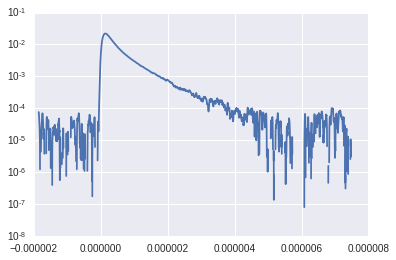

In [85]:
# plots single photon model in semilog axis to check vertical offset correction 
plt.plot(time_f,signal_f)
plt.semilogy()

In [364]:
plt.errorbar(time_f, signal_f, yerr=sigma_f)

ValueError: err must be a scalar, the same dimensions as x, or 2xN.

In [142]:
np.save(results_directory + 'ph1_model.npy',
            np.array(zip(time_f, signal_f, sigma_f)))

In [117]:
# fits the model back to the single photon pulse set to obtain jitter for single photon pulses
def fit_one(time,signal,height_th, time_model, signal_model):
    def one_pulse(x, x_offset=0, amplitude=1):
        """convert the sample single photon pulse into a function
        that can be used in a fit
        """
        x = x - x_offset
        return amplitude * np.interp(x, time_model, signal_model)
    p = Parameters()
    p.add('x_offset', time[hpa.find_idx(signal[:np.argmax(signal)],height_th)], vary=1)
    p.add('amplitude', 1, vary=1)
    result = Model(one_pulse).fit(signal, x=time, params=p)
    return result


In [121]:
results = []
for f in tqdm.tqdm(filelist[mask_1ph]):
    time, signal = hpa.trace_extr(f,h_th=height_th)
    try:
        result = fit_one(time, signal,
        height_th=height_th,
        time_model=time_f,
        signal_model=signal_f)
        results.append(result)
    except:
        pass # some traces were empty for some unknown reason...

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10124 but corresponding boolean dimension is 10000
  from ipykernel import kernelapp as app
100%|██████████| 3736/3736 [00:28<00:00, 129.97it/s]


In [144]:
# Extract Offsets
offsets=[r.best_values['x_offset'] for r in results]
np.savetxt(results_directory+'single_photon_arrival_times.dat',offsets)

295.2 316.8


21.599999999999909

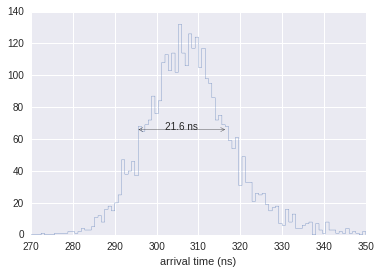

In [149]:
# Plot arrival time distribution
plt.hist(np.array(offsets)*1e9, 
         bins=100, 
         range = [270,350], 
#          alpha=0.5, 
#          label='without shift', 
         histtype='step', 
#          linestyle='-'
        )
plt.xlabel('arrival time (ns)')
# Compute Jitter for single photon pulse
t_hist = np.histogram(np.array(offsets)*1e9, bins=100, range=[270,350])
reload(noshift)
noshift.FWHM(t_hist[1]+np.diff(t_hist[1])[0]/2, t_hist[0]) 

# Fit to 2 photon traces
typically, we want to run over several folders, but as a start, we'll manually search and replace the folder names and variables corresponding to each folder.

In [510]:
# Imports double diode excitation traces
directory_name_90ns = '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/'
results_directory = './'
filelist_90ns = np.array(glob.glob(directory_name_90ns + '*.trc'))
print(filelist_90ns[:2])

[ '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/C2_double_90ns_avg_100_00000.trc'
 '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/C2_double_90ns_avg_100_00001.trc']


In [511]:
data_90ns = np.array([hpa.param_extr(f, t_initial=None, t_final=None, h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist_90ns[:20000])])

100%|██████████| 20000/20000 [01:32<00:00, 216.60it/s]


In [512]:
# Generate Area histograms
areas_90ns = data_90ns['area_win']

# use the area to count the number of photons
pnr_90ns = np.histogram(areas_90ns, 200)

# remove the first bin that is not gaussian, and will affect the threshold detection algorithm

pnr_90ns = [pnr_90ns[0][1:], pnr_90ns[1][1:]]

In [513]:
%matplotlib
plt.hist(areas_90ns,100,
         range=(0,3)
        );

Using matplotlib backend: TkAgg


In [171]:
%matplotlib inline

In [514]:
mask_2ph_90ns = (areas_90ns>0.9)&(areas_90ns<1.35)

In [485]:
# Loads Single Photon Model
ph1_model = np.load(results_directory + 'ph1_model.npy')
time_f, signal_f = ph1_model[:,0], ph1_model[:,1]
time_f, signal_f = time_f[:-100], signal_f[:-100]
plt.plot(time_f,signal_f)

In [546]:
# Plots 2 Photons traces as a check
hpa.pplot(filelist_90ns[mask_2ph_90ns][:5000], plot_every=4)
# plt.plot(time_f*1e6,signal_f, label='single photon model')
plt.legend()
plt.xlim(0.2,0.6);
plt.savefig(results_directory+'persist_90ns.pdf')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


## OPTIMISE AND TEST MCMC & LEAST SQUARES FITS

In [516]:
# MCMC
def fit_two_mcmc(time, signal, 
                 amplitude_init_min=0.7, amplitude_init_max=1.5, 
                 one_x_offset_init=None, 
                 Plot=False, debug=False, 
                 sampling=1e2):
    
    # LIMIT SEARCH FOR OFFSETS
    _t_initial=time[pd.srlatch_rev(signal,0)][0] 
#     _t_final=time[pd.srlatch_rev(signal,np.min(signal))][-1] 
    _t_final=time[np.argmax(signal)]
    
    def model(x, f): 
        # PRIORS
        y_err = sigma0
        print (_t_initial,_t_final, one_x_offset_init)
        one_x_offset = pymc.Uniform("one_x_offset", _t_initial, _t_final, value=_t_initial)
        two_x_offset = pymc.Uniform("two_x_offset", _t_initial, _t_final, value=_t_final)
        one_x_amplitude = pymc.Normal("one_x_amplitude", mu=1, tau=1.0/((0.126657438666)**2), value=1)
        two_x_amplitude = pymc.Normal("two_x_amplitude", mu=1, tau=1.0/((0.126657438666)**2), value=1)
        # MODEL
        @pymc.deterministic(plot=False)
        def mod_two_pulse(x=time, 
                          one_x_offset=one_x_offset, 
                          two_x_offset=two_x_offset, 
                          one_x_amplitude=one_x_amplitude, 
                          two_x_amplitude=two_x_amplitude):
              return one_pulse(x, x_offset=one_x_offset, amplitude=one_x_amplitude)+\
            one_pulse(x, x_offset=two_x_offset, amplitude=two_x_amplitude)

        #likelihoodsy
        y = pymc.Normal("y", mu=mod_two_pulse, tau= 1.0/y_err**2, value=signal, observed=True)
        return locals()

    MDL = pymc.MCMC(model(time,signal), db='pickle') # The sample is stored in a Python serialization (pickle) database
    MDL.use_step_method(pymc.AdaptiveMetropolis, 
        [MDL.one_x_amplitude, MDL.two_x_amplitude],
        scales={MDL.one_x_amplitude:0.126657438666, 
                MDL.two_x_amplitude:0.126657438666}, 
        )
    MDL.sample(iter=sampling, burn=int(sampling*.95), thin=10)  
    # thin: consider every 'thin' samples
    # burn: number of samples to discard: decide by num of samples to run till parameters stabilise at desired precision
    if Plot:
        y_fit = MDL.mod_two_pulse.value #get mcmc fitted values
        plt.plot(time, signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(time,y_fit,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()      
    if debug:
        pymc.Matplot.plot(MDL)
    return MDL #usage: MDL.one_x_offset.value for fitted result

In [517]:
# LEAST SQUARES - performs also MCMC within it
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

def fit_two(time, signal, 
            height_th, 
            filterpts=301, 
            order=3, 
            thres=0.7, 
            min_dist=20, 
            sampling=2e2, 
            debug=False):
    
    # Identify Pulse Region
    [mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time, signal, dt_left=300e-9,dt_right=800e-9, height_th=height_th, Plot=False, method=2)
    window = mask&clamp
    # Use MCMC
    result_mcmc = fit_two_mcmc(time[::10], signal[::10], sampling=sampling, debug=debug)
    # Use Least Squares
    p = Parameters()
    p.add('one_x_offset', result_mcmc.one_x_offset.value, vary=1)
    p.add('two_x_offset', result_mcmc.two_x_offset.value, vary=1)
    p.add('one_amplitude', result_mcmc.one_x_amplitude.value, min=0.5, max=1.5, vary=1) #warning: max >= 2 causes n=2 & noise to be fitted on a tau~0 2ph trace. 
    p.add('two_amplitude', result_mcmc.two_x_amplitude.value, min=0.5, max=1.5, vary=1)

    result = two_pulse_fit.fit(signal,
                               x=time,
                               params=p,
                               )
    return result, result_mcmc

In [518]:
# Test on a single trace
# mdl = fit_two_mcmc(*hpa.trace_extr(filelist_90ns[mask_2ph_90ns][0], t_initial, t_final), sampling=1.5e4)

In [519]:
def testmcmc(i, iters, height_th, Plot=True):
    result, result_mcmc = fit_two(*hpa.trace_extr(filelist_90ns[mask_2ph_90ns][i], 
                                                  t_initial=-2e-6, t_final=None), 
                                                  
                                  height_th=height_th, 
                                  sampling=iters)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.plot(*hpa.trace_extr(filelist_90ns[mask_2ph_90ns][i]), label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result, result_mcmc

In [549]:
%matplotlib
a, b = testmcmc(1,2e4,height_th,Plot=False)

Using matplotlib backend: TkAgg
(3.0015206121092747e-07, 5.6015205385762529e-07, None)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000


 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

In [526]:
results_90ns= np.array([fit_two(*hpa.trace_extr(file, t_initial=-2e-6, t_final=None), 
                                height_th=height_th,
                                sampling=2e4)#1.5e4 for 10us trace, 2ns per pt, sampled every 20 pts.
                    for file
                    in tqdm.tqdm(filelist_90ns[mask_2ph_90ns][::20])])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000
  0%|          | 0/261 [00:00<?, ?it/s]

(3.8038223945378757e-07, 5.4038223492867854e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

  0%|          | 1/261 [00:05<24:56,  5.76s/it]

(3.9901039778947773e-07, 5.9901039213309144e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.3 sec

  1%|          | 2/261 [00:11<24:32,  5.69s/it]

(4.0053270820222814e-07, 5.2053270480839636e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

  1%|          | 3/261 [00:17<25:03,  5.83s/it]

(2.5937574470923689e-07, 4.9937573792157334e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.5 sec

  2%|▏         | 4/261 [00:25<27:25,  6.40s/it]

(3.0007899261886971e-07, 5.0007898696248342e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

  2%|▏         | 5/261 [00:32<28:06,  6.59s/it]

(2.8043076213757582e-07, 5.4043075478427364e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

  2%|▏         | 6/261 [00:39<28:51,  6.79s/it]

(2.7971220623746067e-07, 4.9971220001543575e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

  3%|▎         | 7/261 [00:46<29:31,  6.98s/it]

(3.0003913702320031e-07, 4.4003913306372991e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

  3%|▎         | 8/261 [00:53<28:41,  6.80s/it]

(3.8015205894837125e-07, 5.0015205555453948e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

  3%|▎         | 9/261 [00:59<27:21,  6.51s/it]

(2.992405811230855e-07, 4.992405754666992e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

  4%|▍         | 10/261 [01:05<26:53,  6.43s/it]

(2.2095812845543122e-07, 5.2095811997085178e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

  4%|▍         | 11/261 [01:12<27:15,  6.54s/it]

(8.0432789454611839e-08, 4.8043277814183925e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.7 sec

  5%|▍         | 12/261 [01:19<27:36,  6.65s/it]

(3.0004144749251428e-07, 4.8004144240176662e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.2 sec

  5%|▍         | 13/261 [01:24<25:56,  6.28s/it]

(3.6068404507357734e-07, 5.0068404111410693e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

  5%|▌         | 14/261 [01:30<25:44,  6.25s/it]

(2.796937224829489e-07, 5.3969371512964672e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

  6%|▌         | 15/261 [01:37<25:45,  6.28s/it]

(2.9979798184510834e-07, 5.1979797562308341e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

  6%|▌         | 16/261 [01:43<25:28,  6.24s/it]

(1.2061271612116862e-07, 5.406127042427574e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.6 sec

  7%|▋         | 17/261 [01:51<27:21,  6.73s/it]

(3.6048967684253098e-07, 5.6048967118614468e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

  7%|▋         | 18/261 [01:58<27:48,  6.87s/it]

(1.3939538709223912e-07, 4.9939537691074379e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.6 sec

  7%|▋         | 19/261 [02:06<28:49,  7.14s/it]

(2.1922354367444947e-07, 4.9922353575550866e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

  8%|▊         | 20/261 [02:13<28:57,  7.21s/it]

(3.396706160928916e-07, 5.5967060987086667e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.7 sec

  8%|▊         | 21/261 [02:21<29:49,  7.46s/it]

(2.9918079772958478e-07, 4.7918079263883711e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

  8%|▊         | 22/261 [02:28<29:23,  7.38s/it]

(2.2082903098250626e-07, 5.0082902306356545e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

  9%|▉         | 23/261 [02:35<28:55,  7.29s/it]

(3.2022195234203818e-07, 5.0022194725129052e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

  9%|▉         | 24/261 [02:41<27:07,  6.87s/it]

(3.1908664553939671e-07, 5.3908663931737179e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 10%|▉         | 25/261 [02:47<26:19,  6.69s/it]

(2.3906960809076068e-07, 5.1906960017181987e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 10%|▉         | 26/261 [02:54<26:06,  6.67s/it]

(3.0065516590406688e-07, 4.6065516137895785e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 10%|█         | 27/261 [03:01<26:49,  6.88s/it]

(2.7965213403529529e-07, 4.9965212781327036e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

 11%|█         | 28/261 [03:09<27:17,  7.03s/it]

(2.1998282165278908e-07, 4.799828142994869e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 11%|█         | 29/261 [03:15<26:29,  6.85s/it]

(2.998860684877069e-07, 4.5988606396259787e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 11%|█▏        | 30/261 [03:21<25:29,  6.62s/it]

(3.1951206070185212e-07, 4.7951205617674309e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 12%|█▏        | 31/261 [03:28<25:15,  6.59s/it]

(2.0933296566690619e-08, 5.0093328299136352e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.3 sec

 12%|█▏        | 32/261 [03:37<28:31,  7.47s/it]

(3.1975783687513775e-07, 4.7975783235002872e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.3 sec

 13%|█▎        | 33/261 [03:46<29:44,  7.83s/it]

(2.805301123180817e-07, 5.2053010553041815e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 11.0 sec

 13%|█▎        | 34/261 [03:57<33:30,  8.86s/it]

(3.1958599571990261e-07, 5.1958599006351632e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.3 sec

 13%|█▎        | 35/261 [04:07<34:12,  9.08s/it]

(1.0071870946659079e-07, 4.4071869985073409e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 10.7 sec

 14%|█▍        | 36/261 [04:18<36:12,  9.66s/it]

(2.9956029231442119e-07, 4.7956028722367353e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.3 sec

 14%|█▍        | 37/261 [04:26<34:54,  9.35s/it]

(3.7919119257894313e-07, 5.7919118692255684e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.9 sec

 15%|█▍        | 38/261 [04:35<33:22,  8.98s/it]

(3.1940173579210488e-07, 5.3940172957007996e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.7 sec

 15%|█▍        | 39/261 [04:45<34:21,  9.29s/it]

(-1.9214572338133104e-08, 5.0078541295526254e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.4 sec

 15%|█▌        | 40/261 [04:54<34:36,  9.40s/it]

(3.195995697271222e-07, 4.9959956463637454e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.6 sec

 16%|█▌        | 41/261 [05:03<33:51,  9.23s/it]

(4.0055321361739134e-07, 5.2055321022355956e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.6 sec

 16%|█▌        | 42/261 [05:11<32:10,  8.81s/it]

(8.0093150465442715e-08, 5.2009313802139287e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.8 sec

 16%|█▋        | 43/261 [05:20<32:17,  8.89s/it]

(3.8023292537436536e-07, 5.6023292028361769e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 17%|█▋        | 44/261 [05:27<29:53,  8.26s/it]

(2.4058296543491818e-07, 5.2058295751597737e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 17%|█▋        | 45/261 [05:34<28:13,  7.84s/it]

(3.8017458602418418e-07, 5.4017458149907514e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 18%|█▊        | 46/261 [05:40<26:25,  7.38s/it]

(2.9995133924583e-07, 4.9995133358944371e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 18%|█▊        | 47/261 [05:46<25:14,  7.08s/it]

(2.5984130427602426e-07, 4.9984129748836071e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 18%|█▊        | 48/261 [05:52<24:03,  6.78s/it]

(2.2039841726409441e-07, 4.4039841104206949e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 19%|█▉        | 49/261 [05:59<24:10,  6.84s/it]

(3.1935408236250082e-07, 5.1935407670611453e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 19%|█▉        | 50/261 [06:06<23:53,  6.79s/it]

(1.1950195805498979e-07, 4.5950194843913309e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 20%|█▉        | 51/261 [06:13<24:26,  6.98s/it]

(3.4065314311214032e-07, 6.0065313575883814e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 20%|█▉        | 52/261 [06:21<24:24,  7.01s/it]

(2.8090585239028333e-07, 4.4090584786517429e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 20%|██        | 53/261 [06:27<23:34,  6.80s/it]

(2.9928621289203983e-07, 4.1928620949820805e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 sec

 21%|██        | 54/261 [06:33<22:21,  6.48s/it]

(2.8020895708342477e-07, 4.6020895199267711e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 21%|██        | 55/261 [06:39<21:49,  6.36s/it]

(3.8061588566317315e-07, 5.6061588057242548e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 21%|██▏       | 56/261 [06:45<22:00,  6.44s/it]

(3.2020346858752641e-07, 5.4020346236550148e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 22%|██▏       | 57/261 [06:52<22:09,  6.52s/it]

(1.8059047615710406e-07, 5.0059046710688599e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

 22%|██▏       | 58/261 [06:59<22:54,  6.77s/it]

(2.2028751473701867e-07, 4.6028750794935512e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 23%|██▎       | 59/261 [07:06<22:41,  6.74s/it]

(3.0025054496543891e-07, 4.402505410059685e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 23%|██▎       | 60/261 [07:12<22:09,  6.61s/it]

(2.9925415513030677e-07, 5.1925414890828185e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 23%|██▎       | 61/261 [07:19<22:15,  6.68s/it]

(2.7967408349377844e-07, 4.7967407783739215e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 24%|██▍       | 62/261 [07:26<22:10,  6.69s/it]

(1.1959899776618e-07, 4.7959898758468467e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 24%|██▍       | 63/261 [07:33<22:06,  6.70s/it]

(2.9962151975124526e-07, 5.3962151296358171e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 25%|██▍       | 64/261 [07:39<21:38,  6.59s/it]

(2.4036838059737414e-07, 5.0036837324407196e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 25%|██▍       | 65/261 [07:45<21:25,  6.56s/it]

(3.8045501923718107e-07, 5.2045501527771067e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 25%|██▌       | 66/261 [07:52<20:57,  6.45s/it]

(3.0066758467663118e-07, 4.6066758015152214e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 26%|██▌       | 67/261 [07:58<21:09,  6.54s/it]

(3.0071783738421176e-07, 4.4071783342474136e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 26%|██▌       | 68/261 [08:05<20:40,  6.43s/it]

(3.0082700705930202e-07, 5.0082700140291572e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 26%|██▋       | 69/261 [08:11<20:31,  6.42s/it]

(2.9925271108698554e-07, 4.9925270543059925e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 27%|██▋       | 70/261 [08:17<20:16,  6.37s/it]

(2.9971307209781478e-07, 5.3971306531015123e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 27%|██▋       | 71/261 [08:25<21:09,  6.68s/it]

(3.1922556250690605e-07, 4.9922555741615839e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 28%|██▊       | 72/261 [08:32<21:28,  6.82s/it]

(3.1975234951051537e-07, 5.1975234385412908e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 28%|██▊       | 73/261 [08:38<21:06,  6.74s/it]

(2.9913603238662488e-07, 4.5913602786151584e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 28%|██▊       | 74/261 [08:44<20:27,  6.56s/it]

(2.1932578194159781e-07, 4.99325774022657e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 29%|██▊       | 75/261 [08:51<20:33,  6.63s/it]

(3.0029993124702718e-07, 5.4029992445936363e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 29%|██▉       | 76/261 [08:58<20:38,  6.69s/it]

(2.9933473274763494e-07, 4.3933472878816453e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 30%|██▉       | 77/261 [09:04<19:56,  6.50s/it]

(1.7999986249525688e-07, 4.399998551419547e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

 30%|██▉       | 78/261 [09:11<20:23,  6.69s/it]

(3.007025305250067e-07, 5.007025248686204e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 30%|███       | 79/261 [09:18<20:36,  6.80s/it]

(3.0014715146363358e-07, 4.4014714750416318e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 31%|███       | 80/261 [09:24<19:39,  6.52s/it]

(8.0078132414900203e-08, 4.2007812279904351e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 31%|███       | 81/261 [09:31<19:51,  6.62s/it]

(2.9909559917362867e-07, 4.7909559408288101e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 31%|███▏      | 82/261 [09:37<19:36,  6.57s/it]

(3.0012375796182962e-07, 5.6012375060852743e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 32%|███▏      | 83/261 [09:45<20:19,  6.85s/it]

(3.8058787122273954e-07, 5.6058786613199188e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

 32%|███▏      | 84/261 [09:52<20:30,  6.95s/it]

(3.991874375006693e-07, 5.5918743297556027e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 33%|███▎      | 85/261 [09:59<19:53,  6.78s/it]

(2.9932809014835727e-07, 4.793280850576096e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 33%|███▎      | 86/261 [10:05<19:50,  6.80s/it]

(3.9920072269922464e-07, 5.1920071930539286e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 33%|███▎      | 87/261 [10:12<19:41,  6.79s/it]

(3.0020837890045723e-07, 4.6020837437534819e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.7 sec

 34%|███▎      | 88/261 [10:19<19:41,  6.83s/it]

(2.795065744685087e-07, 4.3950656994339966e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 34%|███▍      | 89/261 [10:27<20:10,  7.04s/it]

(3.9914931475698707e-07, 5.3914931079751666e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 34%|███▍      | 90/261 [10:32<19:00,  6.67s/it]

(6.0739216013031246e-08, 5.007392035689814e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

 35%|███▍      | 91/261 [10:40<19:20,  6.83s/it]

(3.9978238334904418e-07, 5.3978237938957378e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 35%|███▌      | 92/261 [10:46<18:53,  6.71s/it]

(3.0019913702320134e-07, 5.2019913080117642e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

 36%|███▌      | 93/261 [10:53<19:15,  6.88s/it]

(2.3959610628570534e-07, 4.3959610062931904e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.3 sec

 36%|███▌      | 94/261 [11:01<19:41,  7.08s/it]

(2.8063985961050045e-07, 5.0063985338847553e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.6 sec

 36%|███▋      | 95/261 [11:09<20:15,  7.32s/it]

(3.001777651820454e-07, 4.6017776065693637e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 37%|███▋      | 96/261 [11:15<19:19,  7.03s/it]

(3.8016303367761474e-07, 5.0016303028378296e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 37%|███▋      | 97/261 [11:21<18:43,  6.85s/it]

(2.9965068942633585e-07, 4.9965068376994955e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 38%|███▊      | 98/261 [11:28<18:33,  6.83s/it]

(3.7996924312045877e-07, 5.9996923689843384e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 38%|███▊      | 99/261 [11:35<18:01,  6.68s/it]

(3.1923278272351263e-07, 5.7923277537021045e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 38%|███▊      | 100/261 [11:41<18:04,  6.74s/it]

(8.0073511476272259e-08, 5.6007349790094516e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.6 sec

 39%|███▊      | 101/261 [11:49<18:52,  7.08s/it]

(3.9958339417936988e-07, 4.9958339135117673e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 39%|███▉      | 102/261 [11:55<17:46,  6.71s/it]

(3.2056736750449393e-07, 5.0056736241374627e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 39%|███▉      | 103/261 [12:02<17:36,  6.69s/it]

(3.4034440665004684e-07, 5.4034440099366055e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

 40%|███▉      | 104/261 [12:09<17:55,  6.85s/it]

(3.1933617622531796e-07, 4.1933617339712482e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 40%|████      | 105/261 [12:15<17:07,  6.59s/it]

(3.2007321587994446e-07, 4.8007321135483543e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 41%|████      | 106/261 [12:22<16:57,  6.56s/it]

(3.598467888124518e-07, 5.1984678428734277e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.6 sec

 41%|████      | 107/261 [12:29<17:50,  6.95s/it]

(3.0036202510984314e-07, 5.4036201832217959e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.8 sec

 41%|████▏     | 108/261 [12:37<18:33,  7.28s/it]

(2.9907133924583027e-07, 4.7907133415508261e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

 42%|████▏     | 109/261 [12:45<18:29,  7.30s/it]

(3.7971047055728205e-07, 5.3971046603217301e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 42%|████▏     | 110/261 [12:51<17:40,  7.03s/it]

(3.000521334130931e-07, 5.2005212719106817e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.7 sec

 43%|████▎     | 111/261 [12:58<17:27,  6.98s/it]

(3.9963855663424265e-07, 4.9963855380604951e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 sec

 43%|████▎     | 112/261 [13:04<16:23,  6.60s/it]

(2.9919610458878984e-07, 5.1919609836676492e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 43%|████▎     | 113/261 [13:10<16:16,  6.60s/it]

(3.0029675435172004e-07, 4.8029674926097238e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 44%|████▎     | 114/261 [13:17<15:55,  6.50s/it]

(3.2059422671027055e-07, 5.4059422048824563e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.8 sec

 44%|████▍     | 115/261 [13:25<16:58,  6.98s/it]

(3.2075971407489099e-07, 6.2075970559031155e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.5 sec

 44%|████▍     | 116/261 [13:34<18:12,  7.53s/it]

(2.792218091255481e-07, 4.9922180290352318e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.0 sec

 45%|████▍     | 117/261 [13:43<19:18,  8.04s/it]

(2.809485960725935e-07, 4.4094859154748447e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.7 sec

 45%|████▌     | 118/261 [13:52<19:52,  8.34s/it]

(1.5922874392732179e-07, 4.3922873600838098e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.4 sec

 46%|████▌     | 119/261 [14:01<19:59,  8.45s/it]

(2.7902917374648722e-07, 5.5902916582754641e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.5 sec

 46%|████▌     | 120/261 [14:10<20:44,  8.82s/it]

(2.3933993300050726e-07, 5.3933992451592782e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.7 sec

 46%|████▋     | 121/261 [14:20<21:23,  9.17s/it]

(3.0052404677049389e-07, 5.2052404054846897e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.3 sec

 47%|████▋     | 122/261 [14:29<20:51,  9.01s/it]

(3.0076693485713536e-07, 5.2076692863511044e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.0 sec

 47%|████▋     | 123/261 [14:37<20:11,  8.78s/it]

(3.0082238612067407e-07, 4.8082238102992641e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.0 sec

 48%|████▊     | 124/261 [14:46<20:24,  8.94s/it]

(2.8098498596429026e-07, 5.6098497804534945e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 9.9 sec

 48%|████▊     | 125/261 [14:57<21:06,  9.31s/it]

(9.9734738404021258e-08, 4.9973472709124867e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.5 sec

 48%|████▊     | 126/261 [15:05<20:35,  9.15s/it]

(3.0034267492933862e-07, 4.2034267153550685e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 49%|████▊     | 127/261 [15:12<18:47,  8.41s/it]

(2.4025545640964741e-07, 5.4025544792506797e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.3 sec

 49%|████▉     | 128/261 [15:21<18:49,  8.49s/it]

(2.9958050892092056e-07, 5.5958050156761838e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

 49%|████▉     | 129/261 [15:28<17:55,  8.15s/it]

(3.0060404677049356e-07, 4.2060404337666178e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.3 sec

 50%|████▉     | 130/261 [15:34<16:04,  7.36s/it]

(3.2070599566333945e-07, 4.8070599113823041e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 sec

 50%|█████     | 131/261 [15:39<14:52,  6.87s/it]

(3.2045126642146176e-07, 5.0045126133071409e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 51%|█████     | 132/261 [15:45<14:13,  6.62s/it]

(3.0058556301598009e-07, 4.8058555792523243e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 51%|█████     | 133/261 [15:52<13:51,  6.49s/it]

(3.0005877601237077e-07, 4.6005877148726173e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 51%|█████▏    | 134/261 [15:58<13:35,  6.42s/it]

(3.199042628679175e-07, 5.1990425721153121e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 52%|█████▏    | 135/261 [16:04<13:14,  6.31s/it]

(4.0037472986287853e-07, 5.4037472590340813e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 52%|█████▏    | 136/261 [16:10<12:49,  6.16s/it]

(3.8006974847905762e-07, 6.0006974225703269e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 52%|█████▏    | 137/261 [16:16<12:43,  6.16s/it]

(3.005962489365589e-07, 5.2059624271453398e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 53%|█████▎    | 138/261 [16:22<12:53,  6.29s/it]

(2.3977690050953254e-07, 5.1977689259059173e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 53%|█████▎    | 139/261 [16:29<13:03,  6.42s/it]

(2.8052462495346101e-07, 4.4052462042835198e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 54%|█████▎    | 140/261 [16:35<12:55,  6.41s/it]

(3.0031812619287598e-07, 4.203181227990442e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.1 sec

 54%|█████▍    | 141/261 [16:41<12:10,  6.08s/it]

(3.9999465771727552e-07, 5.3999465375780512e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 54%|█████▍    | 142/261 [16:46<11:46,  5.93s/it]

(3.8072967627689135e-07, 5.4072967175178232e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 55%|█████▍    | 143/261 [16:53<11:46,  5.99s/it]

(3.0016361355749733e-07, 5.201636073354724e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 55%|█████▌    | 144/261 [16:59<12:04,  6.20s/it]

(2.9978902877651627e-07, 4.9978902312012998e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 56%|█████▌    | 145/261 [17:06<12:10,  6.30s/it]

(4.0033545188453762e-07, 5.4033544792506722e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 56%|█████▌    | 146/261 [17:11<11:42,  6.11s/it]

(4.0074613780511646e-07, 5.6074613328000743e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 56%|█████▋    | 147/261 [17:18<11:48,  6.22s/it]

(2.3965069112325173e-07, 4.5965068490122681e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

 57%|█████▋    | 148/261 [17:25<12:12,  6.48s/it]

(4.0013935080150578e-07, 5.4013934684203537e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 57%|█████▋    | 149/261 [17:31<12:01,  6.44s/it]

(2.1991061948672407e-07, 4.9991061156778326e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

 57%|█████▋    | 150/261 [17:39<12:20,  6.68s/it]

(3.1982050835528093e-07, 4.798205038301719e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 58%|█████▊    | 151/261 [17:45<11:54,  6.50s/it]

(3.8079581346100718e-07, 5.2079580950153678e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 58%|█████▊    | 152/261 [17:51<11:42,  6.45s/it]

(3.007019529076782e-07, 5.2070194668565328e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 59%|█████▊    | 153/261 [17:58<11:40,  6.48s/it]

(3.0017198900876047e-07, 4.201719856149287e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.1 sec

 59%|█████▉    | 154/261 [18:03<10:57,  6.14s/it]

(3.0054426337699115e-07, 4.6054425885188211e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 59%|█████▉    | 155/261 [18:09<10:43,  6.07s/it]

(2.9921892047326701e-07, 4.5921891594815797e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 60%|█████▉    | 156/261 [18:15<10:37,  6.07s/it]

(2.2080332701138663e-07, 4.6080332022372308e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 60%|██████    | 157/261 [18:21<10:39,  6.15s/it]

(4.0031841217334708e-07, 4.8031840991079256e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 61%|██████    | 158/261 [18:27<10:18,  6.00s/it]

(1.8071148698743011e-07, 4.607114790684893e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.8 sec

 61%|██████    | 159/261 [18:35<11:15,  6.62s/it]

(3.992602172840628e-07, 5.5926021275895377e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 61%|██████▏   | 160/261 [18:42<11:09,  6.62s/it]

(3.194210859726094e-07, 5.194210803162231e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 62%|██████▏   | 161/261 [18:48<10:47,  6.47s/it]

(2.5905834398721475e-07, 4.9905833719955119e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 62%|██████▏   | 162/261 [18:55<10:58,  6.65s/it]

(2.9954556307254504e-07, 5.1954555685052012e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 62%|██████▏   | 163/261 [19:01<10:44,  6.58s/it]

(2.8093531087403859e-07, 4.6093530578329092e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 63%|██████▎   | 164/261 [19:08<10:37,  6.57s/it]

(1.7918426682738751e-07, 4.1918426003972396e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 63%|██████▎   | 165/261 [19:14<10:33,  6.60s/it]

(1.208495392258626e-07, 5.2084952791309002e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 64%|██████▎   | 166/261 [19:21<10:33,  6.66s/it]

(2.9941444393897036e-07, 5.394144371513068e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 64%|██████▍   | 167/261 [19:28<10:17,  6.57s/it]

(3.0012520200515127e-07, 5.0012519634876498e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 64%|██████▍   | 168/261 [19:34<09:59,  6.45s/it]

(2.7904101490172133e-07, 4.3904101037661229e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 65%|██████▍   | 169/261 [19:40<09:36,  6.26s/it]

(2.9921892047326701e-07, 4.392189165137966e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 65%|██████▌   | 170/261 [19:45<09:21,  6.17s/it]

(2.8093588849136666e-07, 4.0093588509753488e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 66%|██████▌   | 171/261 [19:52<09:19,  6.21s/it]

(2.3959379581639179e-07, 5.1959378789745098e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 66%|██████▌   | 172/261 [19:58<09:24,  6.35s/it]

(3.2054455162001676e-07, 4.8054454709490773e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 66%|██████▋   | 173/261 [20:05<09:15,  6.31s/it]

(2.9905112263933132e-07, 5.190511164173064e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 67%|██████▋   | 174/261 [20:10<08:52,  6.12s/it]

(1.4045329317285915e-07, 5.0045328299136382e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 67%|██████▋   | 175/261 [20:17<09:03,  6.32s/it]

(3.7967234781359982e-07, 5.1967234385412941e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 67%|██████▋   | 176/261 [20:24<09:00,  6.36s/it]

(3.0093531030839954e-07, 4.609353057832905e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 sec

 68%|██████▊   | 177/261 [20:29<08:39,  6.18s/it]

(2.9940462444438597e-07, 5.1940461822236105e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 68%|██████▊   | 178/261 [20:36<08:47,  6.35s/it]

(3.2000621226983631e-07, 5.8000620491653413e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 69%|██████▊   | 179/261 [20:42<08:41,  6.36s/it]

(3.0099827059720866e-07, 4.2099826720337688e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.1 sec

 69%|██████▉   | 180/261 [20:48<08:09,  6.04s/it]

(3.2003509313626223e-07, 5.6003508634859868e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 69%|██████▉   | 181/261 [20:54<08:01,  6.02s/it]

(2.6035076270321521e-07, 5.2035075534991303e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 70%|██████▉   | 182/261 [21:01<08:15,  6.27s/it]

(2.1995480721235548e-07, 5.9995479646522152e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.7 sec

 70%|███████   | 183/261 [21:09<08:47,  6.76s/it]

(3.0017372186074595e-07, 5.401737150730824e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 70%|███████   | 184/261 [21:16<08:55,  6.96s/it]

(3.9916924255482008e-07, 5.3916923859534967e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 71%|███████   | 185/261 [21:22<08:27,  6.67s/it]

(3.209439740026883e-07, 4.8094396947757927e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 71%|███████▏  | 186/261 [21:28<08:07,  6.50s/it]

(3.0051278323258658e-07, 4.8051277814183892e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 72%|███████▏  | 187/261 [21:35<08:00,  6.50s/it]

(3.8052866544656732e-07, 5.6052866035581966e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 72%|███████▏  | 188/261 [21:41<07:50,  6.45s/it]

(3.2087379349727344e-07, 5.0087378840652577e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 72%|███████▏  | 189/261 [21:48<07:50,  6.53s/it]

(4.0041920639717419e-07, 5.4041920243770378e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 73%|███████▎  | 190/261 [21:54<07:47,  6.59s/it]

(2.8067682711952569e-07, 4.4067682259441666e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.3 sec

 73%|███████▎  | 191/261 [22:02<08:02,  6.89s/it]

(2.9924577967904363e-07, 5.192457734570187e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 74%|███████▎  | 192/261 [22:09<07:53,  6.86s/it]

(1.7940318379489652e-07, 4.9940317474467845e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

 74%|███████▍  | 193/261 [22:16<07:57,  7.03s/it]

(3.0061559911706342e-07, 5.206155928950385e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 74%|███████▍  | 194/261 [22:24<07:58,  7.15s/it]

(2.9920101433608203e-07, 4.9920100867969574e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.1 sec

 75%|███████▍  | 195/261 [22:32<08:16,  7.52s/it]

(3.6079927973061677e-07, 5.4079927463986911e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 75%|███████▌  | 196/261 [22:39<07:53,  7.28s/it]

(3.4083884708325887e-07, 5.4083884142687257e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 75%|███████▌  | 197/261 [22:45<07:31,  7.06s/it]

(2.7981415569594477e-07, 5.5981414777700396e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 76%|███████▌  | 198/261 [22:51<07:08,  6.80s/it]

(2.202323522821459e-07, 4.8023234492884372e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 76%|███████▌  | 199/261 [22:58<06:57,  6.74s/it]

(2.9925964249492746e-07, 5.1925963627290254e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 77%|███████▋  | 200/261 [23:05<06:57,  6.84s/it]

(2.9981819845160559e-07, 4.3981819449213519e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 77%|███████▋  | 201/261 [23:11<06:35,  6.60s/it]

(9.9319431544816164e-08, 5.3931941910076632e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.3 sec

 77%|███████▋  | 202/261 [23:19<06:46,  6.89s/it]

(2.9919032841550491e-07, 4.9919032275911862e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 78%|███████▊  | 203/261 [23:25<06:26,  6.67s/it]

(2.9949906487759797e-07, 4.5949906035248893e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 78%|███████▊  | 204/261 [23:31<06:12,  6.54s/it]

(3.0051047276327261e-07, 4.6051046823816358e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 79%|███████▊  | 205/261 [23:37<06:00,  6.43s/it]

(2.1993661226650752e-07, 4.9993660434756671e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 79%|███████▉  | 206/261 [23:44<06:03,  6.61s/it]

(2.7911812681507853e-07, 4.7911812115869224e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.7 sec

 79%|███████▉  | 207/261 [23:52<06:19,  7.02s/it]

(2.3943033011242149e-07, 5.1943032219348069e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.0 sec

 80%|███████▉  | 208/261 [24:00<06:32,  7.40s/it]

(3.2058642887633462e-07, 4.8058642435122559e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.7 sec

 80%|████████  | 209/261 [24:07<06:18,  7.28s/it]

(2.3988087162866636e-07, 4.9988086427536418e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

 80%|████████  | 210/261 [24:15<06:12,  7.31s/it]

(3.8092173403862543e-07, 5.409217295135164e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 sec

 81%|████████  | 211/261 [24:21<05:42,  6.85s/it]

(3.0054339695099841e-07, 4.40543392991528e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 81%|████████  | 212/261 [24:27<05:25,  6.63s/it]

(2.7902426399919334e-07, 4.7902425834280704e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 82%|████████▏ | 213/261 [24:33<05:15,  6.58s/it]

(2.7910715208583716e-07, 5.1910714529817361e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 82%|████████▏ | 214/261 [24:41<05:21,  6.84s/it]

(3.9933617396276302e-07, 5.7933616887201536e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 82%|████████▏ | 215/261 [24:46<04:57,  6.47s/it]

(3.1946585131557099e-07, 5.194658456591847e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 83%|████████▎ | 216/261 [24:53<04:49,  6.44s/it]

(1.4019827512231763e-07, 5.2019826437518368e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 83%|████████▎ | 217/261 [24:59<04:48,  6.56s/it]

(3.3993776410733316e-07, 5.1993775901658549e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 84%|████████▎ | 218/261 [25:06<04:47,  6.68s/it]

(-2.6033803119787692e-07, 5.3966194617657791e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.0 sec

 84%|████████▍ | 219/261 [25:15<05:01,  7.17s/it]

(3.2069906425539711e-07, 5.6069905746773356e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 84%|████████▍ | 220/261 [25:21<04:45,  6.95s/it]

(2.2045935589225381e-07, 5.00459347973313e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.8 sec

 85%|████████▍ | 221/261 [25:29<04:53,  7.34s/it]

(3.9991696818658983e-07, 5.1991696479275805e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 85%|████████▌ | 222/261 [25:35<04:26,  6.84s/it]

(4.0067133636107323e-07, 5.606713318359642e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 85%|████████▌ | 223/261 [25:41<04:08,  6.53s/it]

(1.1992708440877884e-07, 5.1992707309600626e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

 86%|████████▌ | 224/261 [25:48<04:10,  6.76s/it]

(3.0014137529034907e-07, 5.0014136963396278e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 86%|████████▌ | 225/261 [25:55<03:58,  6.62s/it]

(3.9938556024435087e-07, 5.1938555685051909e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.3 sec

 87%|████████▋ | 226/261 [26:00<03:40,  6.30s/it]

(4.0062223888814794e-07, 5.4062223492867754e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 87%|████████▋ | 227/261 [26:06<03:28,  6.14s/it]

(3.5984101263916687e-07, 5.1984100811405784e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.4 sec

 87%|████████▋ | 228/261 [26:15<03:48,  6.92s/it]

(3.7984303373417797e-07, 5.598430286434303e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.9 sec

 88%|████████▊ | 229/261 [26:22<03:44,  7.00s/it]

(3.6022137359343243e-07, 5.4022136850268477e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 88%|████████▊ | 230/261 [26:29<03:40,  7.11s/it]

(1.4025690328116137e-07, 4.602568942309433e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.2 sec

 89%|████████▊ | 231/261 [26:37<03:37,  7.24s/it]

(2.9972722372236456e-07, 4.5972721919725552e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.7 sec

 89%|████████▉ | 232/261 [26:45<03:36,  7.47s/it]

(1.8030311153616693e-07, 4.2030310474850338e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.5 sec

 89%|████████▉ | 233/261 [26:52<03:31,  7.54s/it]

(3.2067249385828474e-07, 5.6067248707062119e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 90%|████████▉ | 234/261 [26:59<03:12,  7.14s/it]

(3.8014830443573605e-07, 5.4014829991062702e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 90%|█████████ | 235/261 [27:05<02:58,  6.86s/it]

(3.8037241995920319e-07, 5.803724143028169e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 90%|█████████ | 236/261 [27:11<02:46,  6.67s/it]

(1.8557150055949822e-10, 4.6018555849087103e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 91%|█████████ | 237/261 [27:18<02:41,  6.73s/it]

(2.9919610458878984e-07, 3.9919610176059669e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.6 sec

 91%|█████████ | 238/261 [27:24<02:28,  6.47s/it]

(3.2023234945395275e-07, 5.0023234436320509e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 92%|█████████▏| 239/261 [27:30<02:23,  6.54s/it]

(2.9953805404727463e-07, 3.9953805121908149e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.3 sec

 92%|█████████▏| 240/261 [27:36<02:10,  6.23s/it]

(3.1956808958271764e-07, 4.9956808449196997e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

 92%|█████████▏| 241/261 [27:42<02:05,  6.27s/it]

(3.0034036446002465e-07, 4.4034036050055425e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

 93%|█████████▎| 242/261 [27:48<01:58,  6.21s/it]

(3.6004779958621351e-07, 5.4004779449546585e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 93%|█████████▎| 243/261 [27:55<01:52,  6.27s/it]

(2.2019538477312107e-07, 5.0019537685418026e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.6 sec

 93%|█████████▎| 244/261 [28:02<01:50,  6.53s/it]

(3.4083913589192311e-07, 5.2083913080117545e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 94%|█████████▍| 245/261 [28:09<01:44,  6.54s/it]

(3.0086686265496973e-07, 5.0086685699858344e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

 94%|█████████▍| 246/261 [28:15<01:37,  6.47s/it]

(3.0066180850334625e-07, 5.2066180228132132e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 95%|█████████▍| 247/261 [28:22<01:31,  6.55s/it]

(3.1956462387874668e-07, 5.1956461822236039e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.9 sec

 95%|█████████▌| 248/261 [28:30<01:31,  7.07s/it]

(3.1938296322892716e-07, 4.993829581381795e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 8.0 sec

 95%|█████████▌| 249/261 [28:38<01:28,  7.41s/it]

(3.2050556245034222e-07, 5.2050555679395592e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.8 sec

 96%|█████████▌| 250/261 [28:45<01:20,  7.33s/it]

(3.208948765297647e-07, 5.2089487087337841e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

 96%|█████████▌| 251/261 [28:51<01:09,  6.92s/it]

(3.1978007514228473e-07, 5.1978006948589844e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

 97%|█████████▋| 252/261 [28:57<01:00,  6.71s/it]

(3.0058123088601639e-07, 5.8058122296707558e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 97%|█████████▋| 253/261 [29:04<00:53,  6.66s/it]

(2.7944448060569231e-07, 4.9944447438366739e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.3 sec

 97%|█████████▋| 254/261 [29:10<00:46,  6.63s/it]

(3.0024476879215398e-07, 4.4024476483268357e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 sec

 98%|█████████▊| 255/261 [29:16<00:38,  6.38s/it]

(3.7903321423959352e-07, 5.3903320971448449e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 5.4 sec

 98%|█████████▊| 256/261 [29:22<00:30,  6.15s/it]

(2.7986643006417635e-07, 4.7986642440779006e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.2 sec

 98%|█████████▊| 257/261 [29:28<00:24,  6.24s/it]

(3.1998224120726744e-07, 5.3998223498524252e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

 99%|█████████▉| 258/261 [29:35<00:19,  6.34s/it]

(2.6024881324473069e-07, 5.2024880589142851e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

 99%|█████████▉| 259/261 [29:42<00:12,  6.45s/it]

(3.8095205894837174e-07, 5.6095205385762407e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 6.5 sec

100%|█████████▉| 260/261 [29:48<00:06,  6.54s/it]

(2.9979480494980162e-07, 4.9979479929341533e-07, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 7.1 sec

100%|██████████| 261/261 [29:56<00:00,  6.78s/it]


In [530]:
processed_90ns = pf.extract(results_90ns[:,0])

In [543]:
plt.hist(np.abs(processed_90ns._one_x_offsets_init
    -processed_90ns._two_x_offsets_init)*1e9,60, range=(0,300));
plt.xlabel('time (ns)')
plt.savefig(results_directory+'arrival_times_90ns.pdf')

In [539]:
taus = np.abs(processed_90ns._one_x_offsets_init
    -processed_90ns._two_x_offsets_init)*1e9

In [462]:
hpa.pplot(filelist_90ns[mask_2ph_90ns][taus>100],density=1)
plt.xlim(0,1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2024 but corresponding boolean dimension is 21
  if __name__ == '__main__':


(0, 1)

In [540]:
(mu_t,sigma_t)=norm.fit(taus[taus>30])

In [541]:
(mu_t,sigma_t)

(107.26759142114884, 40.652804396271257)